---
title: "Benchmarking parquet and `dask`"
bibliography: "../../blog.bib"
author: "Peter Amerkhanian"
date: "2024-4-12"
image: thumbnail.png
draft: false
categories: ['Python', 'Data Management']
format:
  html:
    toc: true
    toc-depth: 3
    code-fold: false
    code-tools: true
---

The following example involves a situation where I want to analyze historical data on Bay Area Rapid Transit (BART) ridership at the station/hour level. BART kindly makes such ridership information publicly available on their [open data portal](https://www.bart.gov/about/reports/ridership). This post will examine the following workflow:  

1. Use `bs4` and `requests` to reverse engineer an API for the data and batch download it.
2. Use the [apache parquet](https://parquet.apache.org/) to efficiently store the data locally.
3. Use [`dask`](https://docs.dask.org/en/stable/) for efficient read-in of the data.  

This walkthrough largely serves to highlight the efficiency and the ease of use of `dask` and parquet. I find that:    
**1.) Parquet is a relatively efficient format for storage** (@fig-1)  
![Storage Efficiency](fig1.png){#fig-storage width=70%}  
**2.) `dask`+parquet is a relatively fast for data IO** (@fig-2)  
![Read-in Efficiency](fig2.png){#fig-readin width=70%}


I should note that my adoption of `dask` and parquet storage is due to the influence of two of my day-job coworkers, Batool Hasan and Konrad Franco, after we leveraged them for an internal project with a similar workflow.  

As an aside, I highly recommend watching the ["Background" section of this talk](https://www.youtube.com/watch?v=wKH0-zs2g_U&t=118s) for some basic information on `dask` and how it differs from Spark, DuckDB, and `polars`. The talk also features some comprehensive benchmarks of `dask` and establishes the core differences between [`dask` and Spark] in one group, and [`polars` and DuckDB] in the other.


In [16]:
import pandas as pd
import numpy as np
import dask.dataframe as dd

# Timers
from dask.diagnostics import ProgressBar
from tqdm import tqdm
import time

# I/O Utilities
import requests
from bs4 import BeautifulSoup
import re
import os
from datetime import datetime
import gc

# Display
import matplotlib.pyplot as plt

## Scraping our data
Anyways, to start, here is the homepage of the BART data portal:  

![BART data portal](portal.png){width=80% #fig-zero}  

I'll set up a scraping script using `requests` and `BeautifulSoup` to build access to the BART hourly ridership data.

In [2]:
# URL of the webpage to scrape
url = 'https://afcweb.bart.gov/ridership/origin-destination/'
url

'https://afcweb.bart.gov/ridership/origin-destination/'

In [3]:
# Send an HTTP GET request to the webpage
response = requests.get(url)
# Check if the request was successful
if response.status_code == 200:
    # Parse the content of the webpage with Beautiful Soup
    soup = BeautifulSoup(response.text, 'html.parser')
else:
    print("Failed to retrieve the webpage")


The page is laid out as follows:  

![Origin-destination pairing data](pairings.png){width=80% #fig-pointfive}

My target here is the set of .csv.gz (compressed .csv files) that contain hourly ridership totals between each station pairing. These are all links, thus are in `<a> </a>` tags, and have an `href` that ends in `.csv.gz`. The following captures links to that specification:

In [4]:
links = soup.find_all(
    # final all <a></a> content
    'a',
    # filter to only those links with href ending in .csv.gz
    href=lambda x: x and x.endswith(".csv.gz")
    )
# example output
links[0]

<a href="date-hour-soo-dest-2018.csv.gz"> date-hour-soo-dest-2018.csv.gz</a>

I'm specifically interested in the file that this piece of html links to, which is contained in the `href` tag. I can capture the `href` for each of these pieces of html as follows

In [5]:
files = [l.get('href') for l in links]
# example output
files[0]

'date-hour-soo-dest-2018.csv.gz'

I've now captured the filename, which is a relative url. To download this, I'll need to convert this to a full url, by concatenating the base url to each of the files' relative urls. This leaves us with direct links that each prompt the download of one year's worth of hourly trip totals between the station pairings in the system:

In [6]:
file_urls = [url + f for f in files]
file_urls

['https://afcweb.bart.gov/ridership/origin-destination/date-hour-soo-dest-2018.csv.gz',
 'https://afcweb.bart.gov/ridership/origin-destination/date-hour-soo-dest-2019.csv.gz',
 'https://afcweb.bart.gov/ridership/origin-destination/date-hour-soo-dest-2020.csv.gz',
 'https://afcweb.bart.gov/ridership/origin-destination/date-hour-soo-dest-2021.csv.gz',
 'https://afcweb.bart.gov/ridership/origin-destination/date-hour-soo-dest-2022.csv.gz',
 'https://afcweb.bart.gov/ridership/origin-destination/date-hour-soo-dest-2023.csv.gz',
 'https://afcweb.bart.gov/ridership/origin-destination/date-hour-soo-dest-2024.csv.gz']

This is our target data, so before proceeding to download all of it for local storage, we'll profile the sizes of each file and the total download:

In [7]:
counter = 1
total = 0

for f in file_urls:
    response = requests.head(f)
    # Retrieve the file size for each file
    file_size = int(response.headers.get('Content-Length', 0))
    # Keep track of the total file size
    total += file_size
    print(f"File {counter} size: {file_size} bytes ({round(file_size*10e-7, 2)} mega-bytes)")
    counter += 1
print(f"Total size of data: {total*10e-7} mega-bytes")

File 1 size: 38627139 bytes (38.63 mega-bytes)
File 2 size: 38177159 bytes (38.18 mega-bytes)
File 3 size: 21415653 bytes (21.42 mega-bytes)
File 4 size: 24350926 bytes (24.35 mega-bytes)
File 5 size: 30546036 bytes (30.55 mega-bytes)
File 6 size: 32224174 bytes (32.22 mega-bytes)
File 7 size: 16468035 bytes (16.47 mega-bytes)
Total size of data: 201.809122 mega-bytes


We'll proceed to download all of this into a folder, `data`. Here I take advantage of `tqdm`'s progress bar so that I can track the potentially large job's progress. I also add logic for two conditions:  
 
- make sure that the ingest doesn't re-read files that I already store locally.
- UNLESS, it the data is from the current year, in which case it likely contains more data than the present file for that year.

In [8]:
current_year: str = str(datetime.today().year)
# Create the "data" folder if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')
# Download and save the files
for url in tqdm(file_urls):
    filename: str = os.path.join('data', os.path.basename(url))
    current_year_data: bool = re.search("\d{4}", url)[0] == current_year
    file_exists: bool = os.path.exists(filename)
    if file_exists and not current_year_data:
        pass
    else:
        response = requests.get(url)
        if response.status_code == 200:
            with open(filename, 'wb') as file:
                file.write(response.content)
        else:
            print(f"Failed to download: {url}")

100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Since we are storing a large amount of data in the project directory, we will also set up a `.gitignore` to make sure that it doesn't end up being tracked in version control.

In [9]:
# Create a .gitignore file
gitignore_content = "data/\n"  # Content to exclude the "data" folder
with open('.gitignore', 'w') as gitignore_file:
    gitignore_file.write(gitignore_content)

I now have the raw data stored locally in the following paths.

In [10]:
data_paths = ["data/" + f for f in files]
data_paths

['data/date-hour-soo-dest-2018.csv.gz',
 'data/date-hour-soo-dest-2019.csv.gz',
 'data/date-hour-soo-dest-2020.csv.gz',
 'data/date-hour-soo-dest-2021.csv.gz',
 'data/date-hour-soo-dest-2022.csv.gz',
 'data/date-hour-soo-dest-2023.csv.gz',
 'data/date-hour-soo-dest-2024.csv.gz']

## Storage with parquet

Since these are in a usable form now, I decided against implementing any other processing steps to the data and preserve a raw form in storage, but I'll proceed to batch convert this directory and set of files into a directory of parquet files for more efficient data I/O.  

When we convert to parquet we'll get two core benefits:  

1. The files will be smaller (see @fig-1 ).
2. The files can be read into memory much faster.

To do the batch transfer from `.csv.gz` into parquet, I'll lazily read in the full directory of `.csv.gz` files using `dask`:

Note that what I downloaded above is not all of the BART data I have -- just what is currently on the website. I've previously downloaded extracts going back to 2011:

In [11]:
all_csv_paths = ["data/" + f for f in os.listdir("data") if f.endswith(".gz")]
all_csv_paths

['data/date-hour-soo-dest-2011.csv.gz',
 'data/date-hour-soo-dest-2012.csv.gz',
 'data/date-hour-soo-dest-2013.csv.gz',
 'data/date-hour-soo-dest-2014.csv.gz',
 'data/date-hour-soo-dest-2015.csv.gz',
 'data/date-hour-soo-dest-2016.csv.gz',
 'data/date-hour-soo-dest-2017.csv.gz',
 'data/date-hour-soo-dest-2018.csv.gz',
 'data/date-hour-soo-dest-2019.csv.gz',
 'data/date-hour-soo-dest-2020.csv.gz',
 'data/date-hour-soo-dest-2021.csv.gz',
 'data/date-hour-soo-dest-2022.csv.gz',
 'data/date-hour-soo-dest-2023.csv.gz',
 'data/date-hour-soo-dest-2024.csv.gz']

In [12]:
data = dd.read_csv(all_csv_paths, blocksize=None, compression='gzip')
data.columns = ['Date', 'Hour', 'Start', 'End', 'Riders']
data

,Date,Hour,Start,End,Riders
npartitions=14,,,,,
,string,int64,string,string,int64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


...  

Now I'll establish a subdirectory in `data` that's just for the parquet directory

In [13]:
if not os.path.exists('data/parquet_data'):
    os.makedirs('data/parquet_data')

and I'll write out to that folder using `dask`, with a progress bar to monitor how long this takes (note that these progress bars may not be visible in this document).

In [14]:
pbar = ProgressBar()
pbar.register()

For data of this size, the one-time conversion typically takes under two minutes

In [15]:
#| output: false
data.to_parquet('data/parquet_data', write_index=False)

[########################################] | 100% Completed | 178.79 s


### Storage Comparison
Now that we have the files saved, we can conduct a quick check on how storage size differs. I'll write a helper function to calculate the total bytes of all the files in a given directory.

In [16]:
def get_local_bytes(directory: str) -> int:
    contents: list[str] = os.listdir(directory)
    contents_w_path: list[str] = [os.path.join(directory, f) for f in contents]
    files_not_folders: list[str] = [f for f in contents_w_path
                         if os.path.isfile(f)]
    return sum(os.path.getsize(f) for f in files_not_folders)

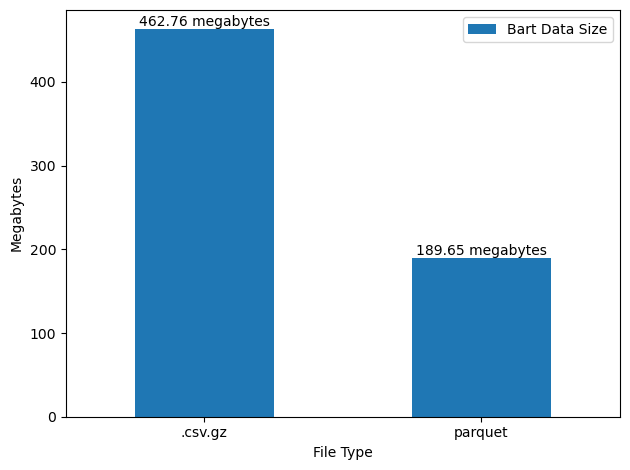

In [17]:
#| label: fig-1
#| fig-cap: "Storage Comparison: .csv.gz versus parquet"
#| code-fold: true
fig, ax = plt.subplots()
pd.DataFrame(
    {
        '.csv.gz': [round(get_local_bytes('data')*10e-7, 2)],
        'parquet': [round(get_local_bytes('data/parquet_data')*10e-7, 2)]
    }, index=['Bart Data Size']
).T.plot.bar(ax=ax)
ax.bar_label(ax.containers[0], fmt="%g megabytes")
ax.set(ylabel='Megabytes', xlabel='File Type')
ax.tick_params(axis='x', rotation=0)
fig.tight_layout()
fig.savefig('fig1.png', dpi=300)

`parquet` is pretty good here.

## Reading parquet

With the data in parquet, it's now very easy to read in and analyze all of this ridership data, and we'll see that it's much faster that working with `.csv.gz` data (see @fig-2 for the efficiency conclusions).

### `dask` with parquet

Here I'll use `dask` to read in about 52 million rows of data in well under 30 seconds, in a single line of code.  

Note that the code for reading in the data, `dd.read_parquet('data/parquet_data')` executes lazily -- it's not reading data into memory yet! I've seen some guides online that benchmark `dask` and `pandas` based on un-computed `dask` commands, which completely misses how `dask` works. Here, I'm going to explicitly call the `compute()` method at the end of the code, which prompts the actual reading in of the data from local file to memory.

In [18]:
#| output: false
start = time.time()
df = dd.read_parquet('data/parquet_data').compute()
dask_parquet_end = time.time() - start

[########################################] | 100% Completed | 31.17 s


Note that I called `start = time.time()` and `dask_parquet_endtime = time.time()` to store the time that it takes to complete this task.

Anyways, we just loaded in fairly large data:

In [19]:
df.shape

(122851920, 5)

In what seems like a short amount of time:

In [20]:
print(round(dask_parquet_end, 2), "seconds")

31.32 seconds


and this data is now all in memory as a `pandas` dataframe, ready for typical use.

In [21]:
df.head()

,Date,Hour,Start,End,Riders
0,2011-01-01,0,12TH,16TH,1
1,2011-01-01,0,12TH,24TH,3
2,2011-01-01,0,12TH,ASHB,2
3,2011-01-01,0,12TH,BAYF,5
4,2011-01-01,0,12TH,CIVC,3


## Benchmarking the read-in task

Before we celebrate too much, lets compare that performance to our other possible cases. We'll compare how the following read-in setups compare:  

- `dask` + parquet
- `dask` + `.csv.gz`
- `pandas` + parquet
- `pandas` + `.csv.gz`

Before I start doing these benchmarks, I'll need to do some memory cleaning so that I can repeatedly read these files in:

In [22]:
#| output: false
del df
gc.collect()

68

### `dask` with .csv.gz

Here we simply use the `.csv.gz` files with `dask` -- does the parallel processing in `dask` make the conversion from `.csv.gz` to parquet not worth it?

In [17]:
#| output: false
if not os.path.exists("times.csv"):
    start = time.time()
    df_dask_csv = dd.read_csv(data_paths,
                              blocksize=None,
                              compression='gzip').compute()
    dask_csv_end = time.time() - start
    del df_dask_csv
    gc.collect()

### `pandas` with .csv.gz

Here we simply use the `.csv.gz` files with `pandas` for read-in -- how do things look if we use no new libraries and do no file conversions?

In [18]:
#| output: false
if not os.path.exists("times.csv"):
    dfs = []
    start = time.time()
    for csv_path in tqdm(data_paths):
        dfs.append(pd.read_csv(csv_path))
    df_pandas = pd.concat(dfs)
    pandas_csv_end = time.time() - start
    del df_pandas
    gc.collect()

### `pandas` with parquet

Finally, we'll take advantage of the fact that `pandas` also supports the read-in of directories of parquet data and try the parquet files with `pandas` for read-in -- can we avoid using `dask`?

In [19]:
#| output: false
if not os.path.exists("times.csv"):
    start = time.time()
    df_pandas_parquet = pd.read_parquet('data/parquet_data')
    pandas_parquet_end = time.time() - start
    del df_pandas_parquet
    gc.collect()

We'll answer all of those questions at once with a plot:

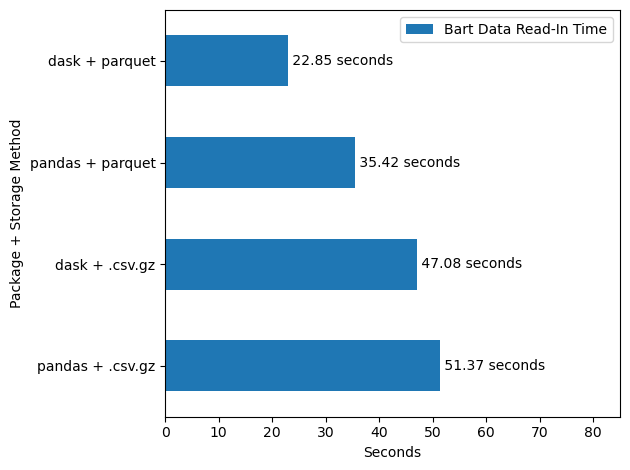

In [20]:
#| label: fig-2
#| fig-cap: "Storage Comparison: .csv.gz versus parquet"
#| code-fold: true
if not os.path.exists("times.csv"):
    times = pd.DataFrame(
        {
            'dask + parquet': [round(dask_parquet_end, 2)],
            'dask + .csv.gz': [round(dask_csv_end, 2)],
            'pandas + parquet': [round(pandas_parquet_end, 2)],
            'pandas + .csv.gz': [round(pandas_csv_end, 2)],
        }, index=['Bart Data Read-In Time']
    )
    times.to_csv('times.csv')
else:
    times = pd.read_csv('times.csv', index_col=0)
fig, ax = plt.subplots()
times.T.sort_values(by='Bart Data Read-In Time', ascending=False).plot.barh(ax=ax)
ax.bar_label(ax.containers[0], fmt=" %g seconds")
ax.set(xlabel='Seconds', ylabel='Package + Storage Method', xlim=(0, 85))
ax.tick_params(axis='x', rotation=0)
fig.tight_layout()
fig.savefig('fig2.png', dpi=300)

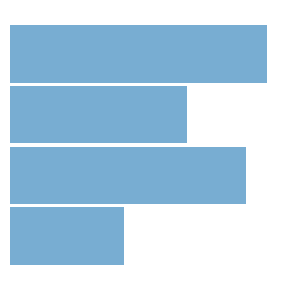

In [21]:
#| output: false
#| echo: false
import seaborn as sns
thumbnail = times.copy()
fig, ax = plt.subplots(figsize=(3, 3))
thumbnail.T.plot.barh(ax=ax, legend=False, alpha=.6, width=.95)
ax.set_axis_off()
fig.tight_layout()
fig.savefig('thumbnail.png', bbox_inches='tight', dpi=300)

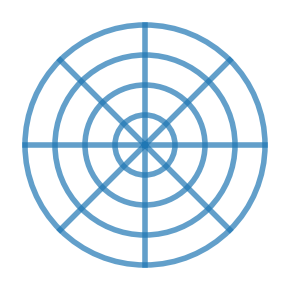

In [41]:
#| output: false
#| echo: false
import seaborn as sns
thumbnail = times.copy()
fig, ax = plt.subplots(figsize=(3, 3))
import numpy as np


# Set the background color
ax.set_facecolor('#f2f2f2')
ax.set_xlim(.5, 9.5)
ax.set_ylim(.5, 9.5)

# Draw a web with lines radiating from the center
num_lines = 8
for i in range(num_lines):
    angle = i * (2 * np.pi / num_lines)
    x = [5, 5 + 4 * np.cos(angle)]
    y = [5, 5 + 4 * np.sin(angle)]
    ax.plot(x, y, color='tab:blue', lw=4, alpha=.7)

# Draw concentric circles to complete the web
for radius in range(1, 5):
    circle = plt.Circle((5, 5), radius * 1, color='tab:blue', fill=False, lw=4, alpha=.7)
    ax.add_patch(circle)

# Remove axes for icon-like appearance
ax.axis('off')
fig.tight_layout()
# Save the icon
fig.savefig('../pdf-scraping/thumbnail.png', bbox_inches='tight', dpi=300)


Again, parquet, and especially parquet with `dask`, looks pretty good here.

### Some reflection

These differences in seconds aren't so massive in the context of this 52 million row dataset. Indeed, in my experience with smaller row counts, just using .csv.gz/.csv with `pandas` is faster, as `dask` has to take time to set up parallel jobs at the start, and a parquet conversion has a fixed time cost up front. However, as the size of the data increases, one would expect the gap between the dask + parquet approach to start to diverge from the others more, and the efficiency gains become more important.  

Even beyond the time differences, I'm especially partial to `dask`+parquet due to the difference in how much code is required at read-in. I also love the fact that `dask` can read in an entire directory of data easily in one line of code:  

```{python}
df = dd.read_parquet('data/parquet_data').compute()
```